In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
import keras
from keras import layers
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-04-08 15:36:08.946392: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 15:36:08.946618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 15:36:09.107568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/favorita-grocery-sales-forecasting/test.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/stores.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/items.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/holidays_events.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/transactions.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/train.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/oil.csv.7z
/kaggle/input/favorita-grocery-sales-forecasting/sample_submission.csv.7z


In [3]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import pacf,acf
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.optimizers import SGD
import math

In [5]:
!pip install py7zr
from subprocess import check_output
import py7zr
for dirname, _, filenames in os.walk('/kaggle/input/favorita-grocery-sales-forecasting'):
    for filename in filenames:
        archive = py7zr.SevenZipFile(os.path.join(dirname, filename), mode='r')
        archive.extractall(path="/kaggle/working")
        archive.close()
print(check_output(["ls", "../working"]).decode("utf8"))
import warnings
warnings.simplefilter('ignore')
#Tip 1.3. Ignore all warnings about later execution ¶
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 47.3 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 19.4 MB/s eta 0:00:00
holidays_events.csv
items.csv
oil.csv
sample_submission.csv
stores.csv
test.csv
train.csv
transactions.csv



In [157]:
import scipy as sp
from scipy.interpolate import CubicSpline,interp1d

In [6]:
df1 = pd.read_csv("../working/train.csv")
df1

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN
...,...,...,...,...,...,...
125497035,125497035,2017-08-15,54,2089339,4.0,False
125497036,125497036,2017-08-15,54,2106464,1.0,True
125497037,125497037,2017-08-15,54,2110456,192.0,False
125497038,125497038,2017-08-15,54,2113914,198.0,True


In [7]:
df2 = pd.read_csv('../working/test.csv')
df2.head(10)

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False
5,125497045,2017-08-16,1,105574,False
6,125497046,2017-08-16,1,105575,False
7,125497047,2017-08-16,1,105576,False
8,125497048,2017-08-16,1,105577,False
9,125497049,2017-08-16,1,105693,False


In [8]:
df3 = pd.read_csv('../working/stores.csv')
df3.head(10)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4
5,6,Quito,Pichincha,D,13
6,7,Quito,Pichincha,D,8
7,8,Quito,Pichincha,D,8
8,9,Quito,Pichincha,B,6
9,10,Quito,Pichincha,C,15


In [9]:
# merging the df1 and the df3 columns on the store_nbr.
df1 = df1.merge(df3, on = ['store_nbr'])
df1.head(10)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,25,103665,7.0,NaN,Salinas,Santa Elena,D,1
1,1,2013-01-01,25,105574,1.0,NaN,Salinas,Santa Elena,D,1
2,2,2013-01-01,25,105575,2.0,NaN,Salinas,Santa Elena,D,1
3,3,2013-01-01,25,108079,1.0,NaN,Salinas,Santa Elena,D,1
4,4,2013-01-01,25,108701,1.0,NaN,Salinas,Santa Elena,D,1
5,5,2013-01-01,25,108786,3.0,NaN,Salinas,Santa Elena,D,1
6,6,2013-01-01,25,108797,1.0,NaN,Salinas,Santa Elena,D,1
7,7,2013-01-01,25,108952,1.0,NaN,Salinas,Santa Elena,D,1
8,8,2013-01-01,25,111397,13.0,NaN,Salinas,Santa Elena,D,1
9,9,2013-01-01,25,114790,3.0,NaN,Salinas,Santa Elena,D,1


In [10]:
print(df1['date'].unique())
print(df1['type'].unique())
print(df1['state'].unique())
print(df1['cluster'].unique())
print(df1['city'].unique())

['2013-01-01' '2013-01-02' '2013-01-03' ... '2017-08-13' '2017-08-14'
 '2017-08-15']
['D' 'B' 'C' 'E' 'A']
['Santa Elena' 'Pichincha' 'Santo Domingo de los Tsachilas' 'Cotopaxi'
 'Chimborazo' 'Imbabura' 'Bolivar' 'Tungurahua' 'Guayas' 'Los Rios'
 'Azuay' 'Loja' 'El Oro' 'Esmeraldas' 'Manabi' 'Pastaza']
[ 1 13  8  9  4  6 15  7  3 12 16 10  2  5 11 14 17]
['Salinas' 'Quito' 'Santo Domingo' 'Cayambe' 'Latacunga' 'Riobamba'
 'Ibarra' 'Guaranda' 'Ambato' 'Guayaquil' 'Daule' 'Babahoyo' 'Quevedo'
 'Playas' 'Cuenca' 'Loja' 'Machala' 'Esmeraldas' 'El Carmen' 'Libertad'
 'Manta' 'Puyo']


In [11]:
df1.isna().sum()

id                    0
date                  0
store_nbr             0
item_nbr              0
unit_sales            0
onpromotion    21657651
city                  0
state                 0
type                  0
cluster               0
dtype: int64

In [12]:
# for time series models we don't need extra variables so we will remove the promotions column and rest we will keep because to do forecasting at
# at different levels by doing the accredation on forecasted time series
df1.drop(columns = ['onpromotion'], inplace = True)
df1.head(10)

,id,date,store_nbr,item_nbr,unit_sales,city,state,type,cluster
0,0,2013-01-01,25,103665,7.0,Salinas,Santa Elena,D,1
1,1,2013-01-01,25,105574,1.0,Salinas,Santa Elena,D,1
2,2,2013-01-01,25,105575,2.0,Salinas,Santa Elena,D,1
3,3,2013-01-01,25,108079,1.0,Salinas,Santa Elena,D,1
4,4,2013-01-01,25,108701,1.0,Salinas,Santa Elena,D,1
5,5,2013-01-01,25,108786,3.0,Salinas,Santa Elena,D,1
6,6,2013-01-01,25,108797,1.0,Salinas,Santa Elena,D,1
7,7,2013-01-01,25,108952,1.0,Salinas,Santa Elena,D,1
8,8,2013-01-01,25,111397,13.0,Salinas,Santa Elena,D,1
9,9,2013-01-01,25,114790,3.0,Salinas,Santa Elena,D,1


In [369]:
# Now we will do the time series forecasting but for some item_nbr only
itn = 108701
stn = 25
df_new1 = df1[(df1['item_nbr']==itn) & (df1['store_nbr']==stn)]
df_new1

,id,date,store_nbr,item_nbr,unit_sales,city,state,type,cluster
4,4,2013-01-01,25,108701,1.0,Salinas,Santa Elena,D,1
19820,19820,2013-01-02,25,108701,1.0,Salinas,Santa Elena,D,1
60701,60701,2013-01-03,25,108701,2.0,Salinas,Santa Elena,D,1
141839,141839,2013-01-05,25,108701,1.0,Salinas,Santa Elena,D,1
183823,183823,2013-01-06,25,108701,1.0,Salinas,Santa Elena,D,1
...,...,...,...,...,...,...,...,...,...
124919673,124919673,2017-08-10,25,108701,1.0,Salinas,Santa Elena,D,1
125019502,125019502,2017-08-11,25,108701,3.0,Salinas,Santa Elena,D,1
125125152,125125152,2017-08-12,25,108701,4.0,Salinas,Santa Elena,D,1
125336146,125336146,2017-08-14,25,108701,1.0,Salinas,Santa Elena,D,1


In [370]:
fig1 = px.line(df_new1,x = 'date',y = 'unit_sales',title = f"Sales Vs Date for item number '{itn}' at store number '{stn}'.")
fig1.update_layout(
    xaxis_title = 'Date',yaxis_title = 'Sales',legend_title = 'Sales vs Date at particular store level'
)
fig1.show()

In [371]:
# Now as we can see that some of the dates are missing so therefore we will consider the unit sales at that day to be zero.
# first lets check the datatype of the date column in df_new1.
print(df_new1['date'].dtype)
# as the datatype of the date is object lets convert it into 'date' datatype.
df_new1['date'] = pd.to_datetime(df_new1['date'])

object


In [372]:
# checking the dtype
print(df_new1['date'].dtype)
# now lets check which all dates are missing.
# creating a date range
date_range = pd.date_range(start = df_new1['date'].min(),end = df_new1['date'].max()) 
df_new11 = pd.DataFrame(date_range,columns = ['date'])
df_new11 = df_new11.merge(df_new1,on = ['date'],how = 'left')
df_new11
#print(date_range)

datetime64[ns]


,date,id,store_nbr,item_nbr,unit_sales,city,state,type,cluster
0,2013-01-01,4.0,25.0,108701.0,1.0,Salinas,Santa Elena,D,1.0
1,2013-01-02,19820.0,25.0,108701.0,1.0,Salinas,Santa Elena,D,1.0
2,2013-01-03,60701.0,25.0,108701.0,2.0,Salinas,Santa Elena,D,1.0
3,2013-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,141839.0,25.0,108701.0,1.0,Salinas,Santa Elena,D,1.0
...,...,...,...,...,...,...,...,...,...
1683,2017-08-11,125019502.0,25.0,108701.0,3.0,Salinas,Santa Elena,D,1.0
1684,2017-08-12,125125152.0,25.0,108701.0,4.0,Salinas,Santa Elena,D,1.0
1685,2017-08-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1686,2017-08-14,125336146.0,25.0,108701.0,1.0,Salinas,Santa Elena,D,1.0


In [373]:
df_new11.isna().sum()

date            0
id            942
store_nbr     942
item_nbr      942
unit_sales    942
city          942
state         942
type          942
cluster       942
dtype: int64

In [374]:
#id is not important as SKU id is named as item_nbr
df_new11.drop(columns = ['id'],inplace = True)
df_new11.head(2)

,date,store_nbr,item_nbr,unit_sales,city,state,type,cluster
0,2013-01-01,25.0,108701.0,1.0,Salinas,Santa Elena,D,1.0
1,2013-01-02,25.0,108701.0,1.0,Salinas,Santa Elena,D,1.0


In [375]:
# now filling  the NaN values.
cty = df_new11['city'].mode()[0]
sta  = df_new11['state'].mode()[0]
clu = df_new11['cluster'].mode()[0]
typ = df_new11['type'].mode()[0]
itn1 = df_new11['item_nbr'].mode()[0]
stn1 = df_new11['store_nbr'].mode()[0]
df_new11['city'].fillna(cty,inplace = True)
df_new11['state'].fillna(sta,inplace = True)
df_new11['cluster'].fillna(clu,inplace = True)
df_new11['type'].fillna(typ,inplace = True)
df_new11['item_nbr'].fillna(itn1,inplace = True)
df_new11['store_nbr'].fillna(stn1,inplace = True)

In [376]:
# now filling the missing sales using interpolation technique
values = df_new11['unit_sales'].values
nan_indices = np.where(np.isnan(values))[0]
non_nan_indices = np.where(~np.isnan(values))[0]
cs = interp1d(non_nan_indices, values[non_nan_indices], kind='linear', fill_value='extrapolate')
# cs = CubicSpline(non_nan_indices, values[non_nan_indices],bc_type = 'natural')
for idx in nan_indices:
    values[idx] = max(0,np.round(cs(idx)))
df_new11['unit_sales'] = values
df_new11.isna().sum()

date          0
store_nbr     0
item_nbr      0
unit_sales    0
city          0
state         0
type          0
cluster       0
dtype: int64

In [377]:
# visualizing with the graph
fig2 = px.line(df_new11,x = 'date',y = 'unit_sales',title = f"Sales Vs Date for item number '{itn}' at store number '{stn}'.")
fig2.update_layout(
    xaxis_title = 'Date',yaxis_title = 'Sales',legend_title = 'Sales vs Date at particular store level'
)
fig2.show()

# RNN Modelling Univariate

In [378]:
df_model = df_new11[['date','unit_sales']]
label_enc = LabelEncoder()
label_enc.fit(df_model['date'])
df_model['day'] = label_enc.transform(df_model['date'])
df_model.drop(columns = ['date'], inplace = True)

In [379]:
df_model

,unit_sales,day
0,1.0,0
1,1.0,1
2,2.0,2
3,2.0,3
4,1.0,4
...,...,...
1683,3.0,1683
1684,4.0,1684
1685,2.0,1685
1686,1.0,1686


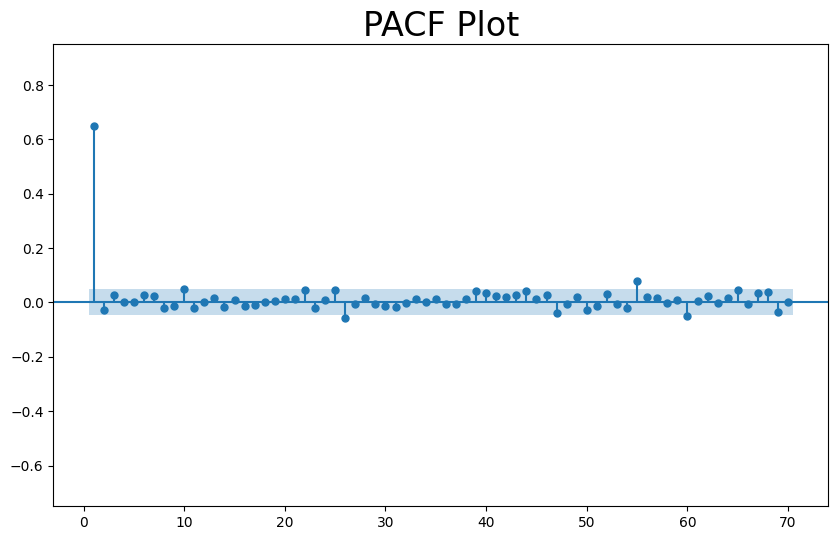

In [380]:
X1 = df_model['unit_sales'].values
lags = 70
acf_fig, ax = plt.subplots(figsize=(10, 6))
plot_pacf(X1, lags=lags, zero  = False, ax=ax)
ax.set_title("PACF Plot", size=24)
ax.set_ylim(-0.75, 0.95)
plt.show()

In [381]:
pacf_values, conf_int = pacf(X1, nlags = 100, alpha = 0.05)
# now setting the significanc level (e.g. 0.05 for 95% confidence interval) generally we take this only
significant_lags_pacf1 = np.where(np.abs(pacf_values)> 0.05)[0]
significant_lags_pacf = significant_lags_pacf1[1:]
significant_lags_pacf

array([ 1, 26, 55, 60])

In [382]:
#Now let's create the lagged Dataframe
lagged_data = pd.concat([df_model['unit_sales'].shift(lag) for lag in range (1,max(significant_lags_pacf)+1)], axis = 1)
lagged_data.columns = [f'Lag_{lag}' for lag in range (1,max(significant_lags_pacf)+1)]
lagged_data_dropped = lagged_data.dropna()
lagged_data_dropped

,Lag_1,Lag_2,Lag_3,Lag_4,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,...,Lag_51,Lag_52,Lag_53,Lag_54,Lag_55,Lag_56,Lag_57,Lag_58,Lag_59,Lag_60
60,2.0,1.0,2.0,3.0,1.0,2.0,4.0,2.0,2.0,1.0,...,1.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0,1.0
61,2.0,2.0,1.0,2.0,3.0,1.0,2.0,4.0,2.0,2.0,...,1.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0,1.0
62,3.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,4.0,2.0,...,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,2.0
63,3.0,3.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,4.0,...,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0
64,4.0,3.0,3.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1683,1.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,1.0,...,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1684,3.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,1.0,...,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1685,4.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,1.0,...,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0
1686,2.0,4.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,...,1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0


In [383]:
df_output1 = lagged_data_dropped[[f'Lag_{lag}' for lag in significant_lags_pacf]]
df_output1

,Lag_1,Lag_26,Lag_55,Lag_60
60,2.0,5.0,1.0,1.0
61,2.0,3.0,3.0,1.0
62,3.0,1.0,1.0,2.0
63,3.0,2.0,1.0,2.0
64,4.0,8.0,1.0,1.0
...,...,...,...,...
1683,1.0,2.0,1.0,1.0
1684,3.0,1.0,1.0,1.0
1685,4.0,1.0,1.0,1.0
1686,2.0,1.0,2.0,1.0


In [384]:
X = df_output1
y = df_model['unit_sales'].iloc[df_output1.index[0]:,]
T = X.shape[1]

In [385]:
X = X.to_numpy()
X = X.reshape(X.shape[0],X.shape[1],1)
a = math.trunc(len(X)*0.6)
b = math.trunc(len(X)*0.2)
c = math.trunc(len(X)*0.2)
X_train = X[0:a]
y_train = y[0:a]
X_val = X[a:a+b]
y_val = y[a:a+b]
X_test = X[a+b:a+b+c]
y_test = y[a+b:a+b+c]

In [386]:
Horizon = 1 # the number of variables u want to predict.
model  = Sequential()
model.add(SimpleRNN(100,return_sequences= True,input_shape = (T,1)))
model.add(SimpleRNN(100))
model.add(Dense(Horizon))
model.compile(optimizer = 'RMSprop', loss = 'mse')
model.summary()

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_34 (SimpleRNN)       │ (None, 4, 100)         │        10,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_35 (SimpleRNN)       │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

In [387]:
model.fit(X_train,y_train, validation_data = (X_val,y_val),epochs = 100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 1.5847 - val_loss: 0.4843
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8079 - val_loss: 0.5620
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8530 - val_loss: 0.4455
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6602 - val_loss: 0.3554
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7511 - val_loss: 0.3747
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7991 - val_loss: 0.4358
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6280 - val_loss: 0.3547
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6180 - val_loss: 0.3772
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7028 - val_loss: 0.3492
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6746 - val_loss: 0.3587
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6715 - val_loss: 0.3733
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

In [388]:
y_train_predicted = model.predict(X_train)
y_test_predicted = model.predict(X_test)
y_val_predicted = model.predict(X_val)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


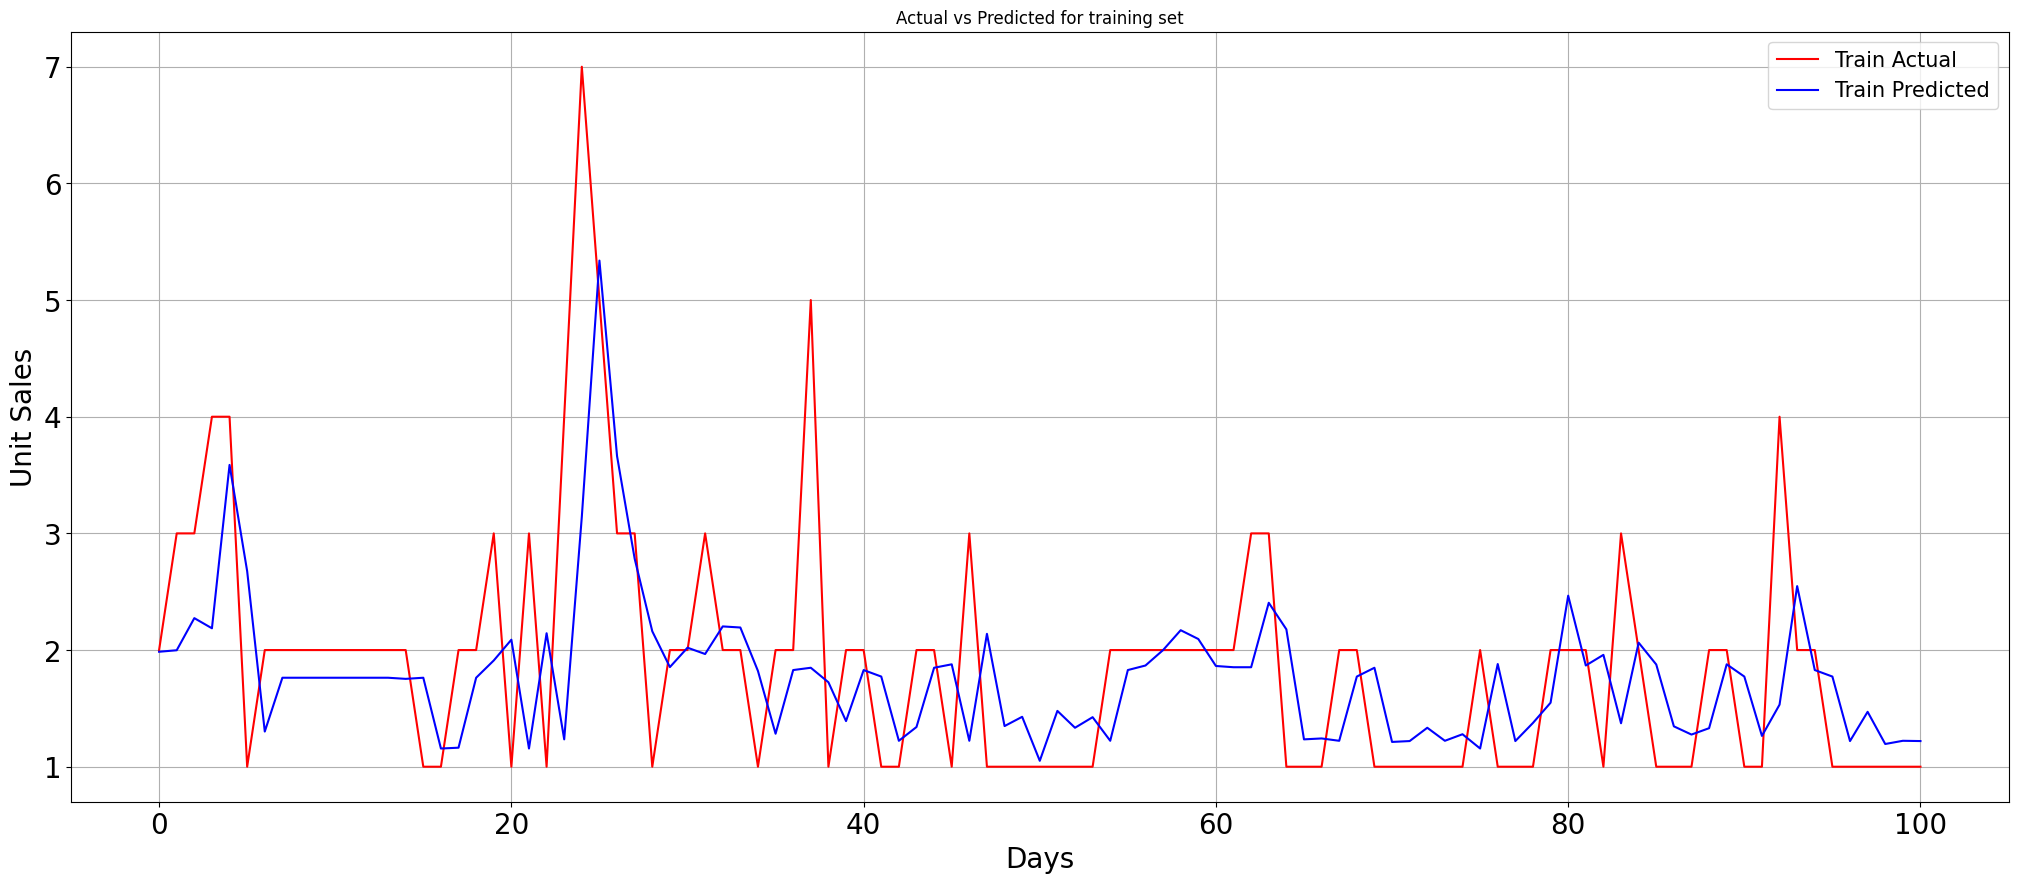

In [389]:
len_train = range(len(X_train))
fig1 = plt.subplots(figsize = (25,10))
plt.plot(len_train[:101],y_train[:101], label = 'Train Actual',color = 'red')
plt.plot(len_train[:101],y_train_predicted[:101], label = 'Train Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for training set')
plt.show()

In [390]:
print("MAE: ",mean_absolute_error(y_train,y_train_predicted))
print("MSE: ",mean_squared_error(y_train,y_train_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_train,y_train_predicted)))

MAE:  0.4546591643182958
MSE:  0.5230957169762083
RMSE:  0.7232535634037404


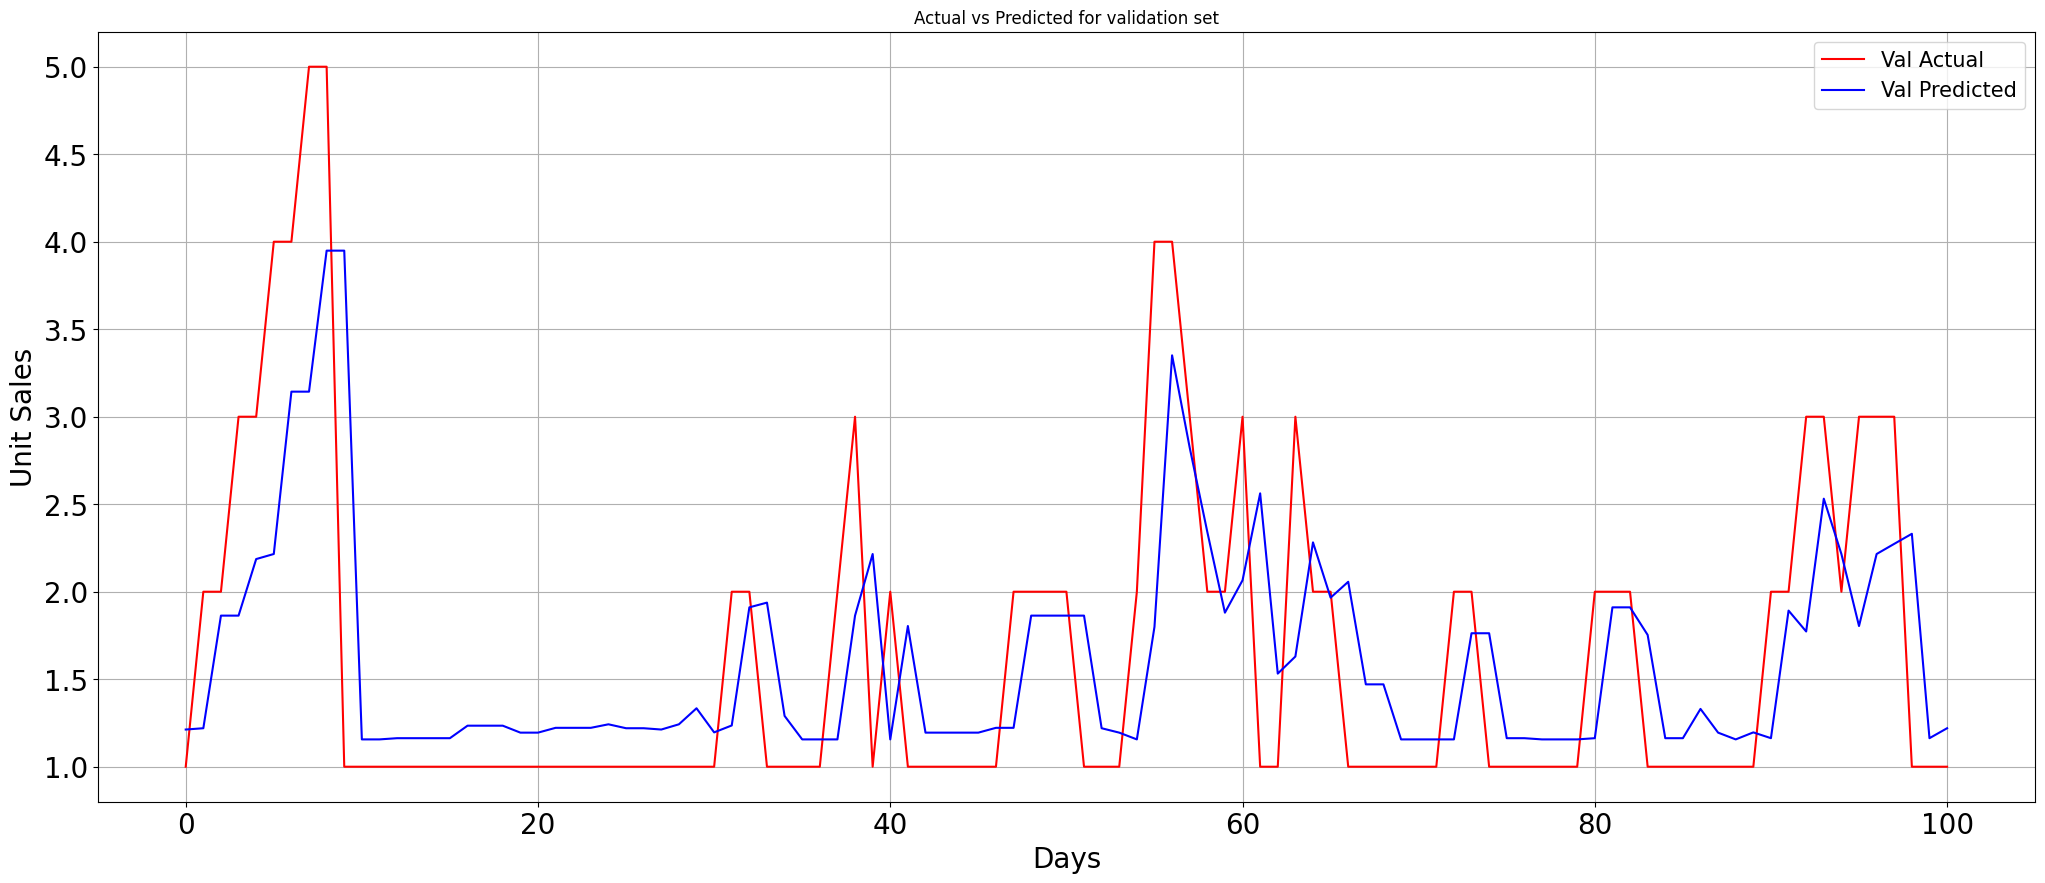

In [391]:
len_val = range(len(X_val))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_val[:101],y_val[:101], label = 'Val Actual',color = 'red')
plt.plot(len_val[:101],y_val_predicted[:101], label = 'Val Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Actual vs Predicted for validation set')
plt.show()

In [392]:
print("MAE: ",mean_absolute_error(y_val,y_val_predicted))
print("MSE: ",mean_squared_error(y_val,y_val_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_val,y_val_predicted)))

MAE:  0.4397426601556631
MSE:  0.3862821217950858
RMSE:  0.6215159867574492


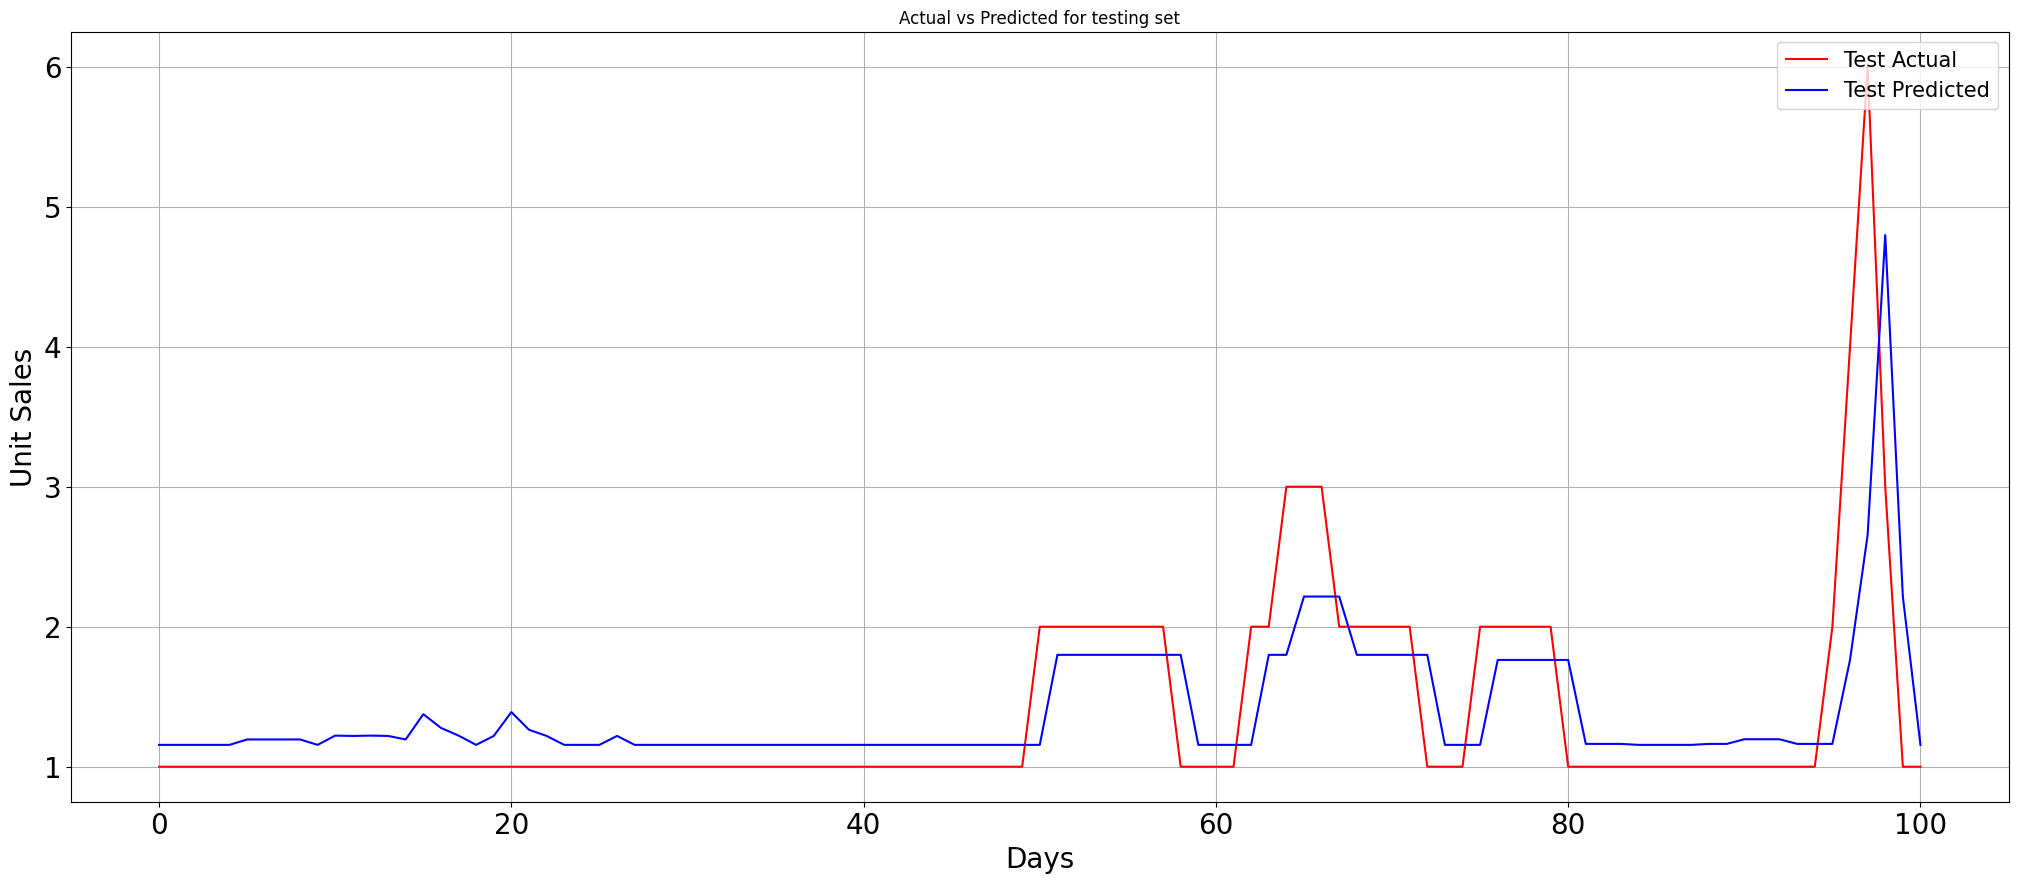

In [393]:
len_test = range(len(X_test))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_test[:101],y_test[:101], label = 'Test Actual',color = 'red')
plt.plot(len_test[:101],y_test_predicted[:101], label = 'Test Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for testing set')
plt.show()

In [394]:
print("MAE: ",mean_absolute_error(y_test,y_test_predicted))
print("MSE: ",mean_squared_error(y_test,y_test_predicted))
print("RMSE: ",math.sqrt(mean_squared_error(y_test,y_test_predicted)))

MAE:  0.3506266084084144
MSE:  0.2989283807956498
RMSE:  0.5467434323296896


# LSTM Univariate

In [395]:
model1 = Sequential()
model1.add(LSTM(100, input_shape = (T,1),return_sequences = True))# 1 is set because we want to predict one variable only
model1.add(LSTM(100))
model1.add(Dense(Horizon))
model1.compile(optimizer = 'RMSprop',loss = 'mse')
model1.summary()

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 4, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

In [396]:
model1.fit(X_train,y_train,validation_data = (X_val,y_val),epochs = 100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 1.6142 - val_loss: 0.4531
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7001 - val_loss: 0.5300
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8963 - val_loss: 0.4445
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7359 - val_loss: 0.4600
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7642 - val_loss: 0.4180
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6994 - val_loss: 0.4682
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7250 - val_loss: 0.4184
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7697 - val_loss: 0.4129
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.7577 - val_loss: 0.4245
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7476 - val_loss: 0.4088
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6750 - val_loss: 0.4342
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step

In [397]:
y_train_predicted1 = model1.predict(X_train)
y_test_predicted1 = model1.predict(X_test)
y_val_predicted1 = model1.predict(X_val)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


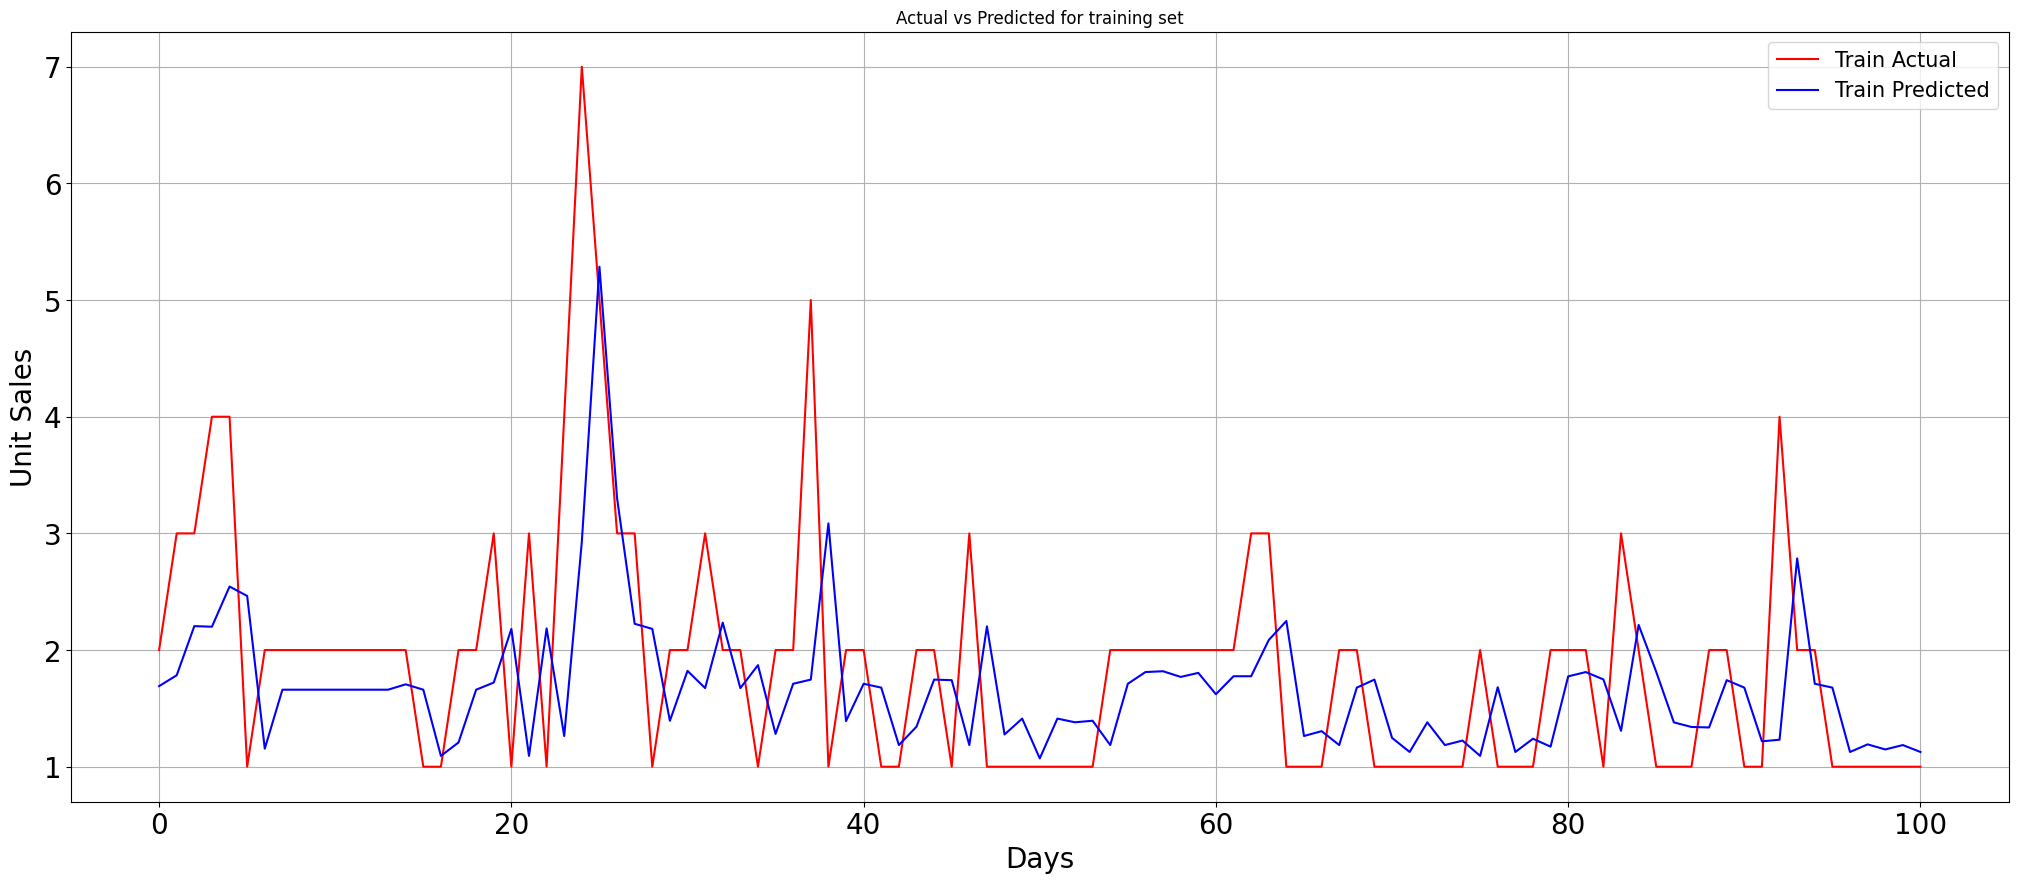

In [398]:
len_train = range(len(X_train))
fig1 = plt.subplots(figsize = (25,10))
plt.plot(len_train[:101],y_train[:101], label = 'Train Actual',color = 'red')
plt.plot(len_train[:101],y_train_predicted1[:101], label = 'Train Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for training set')
plt.show()

In [399]:
print("MAE: ",mean_absolute_error(y_train,y_train_predicted1))
print("MSE: ",mean_squared_error(y_train,y_train_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_train,y_train_predicted1)))

MAE:  0.4751487557516723
MSE:  0.5668999153428272
RMSE:  0.7529275631445745


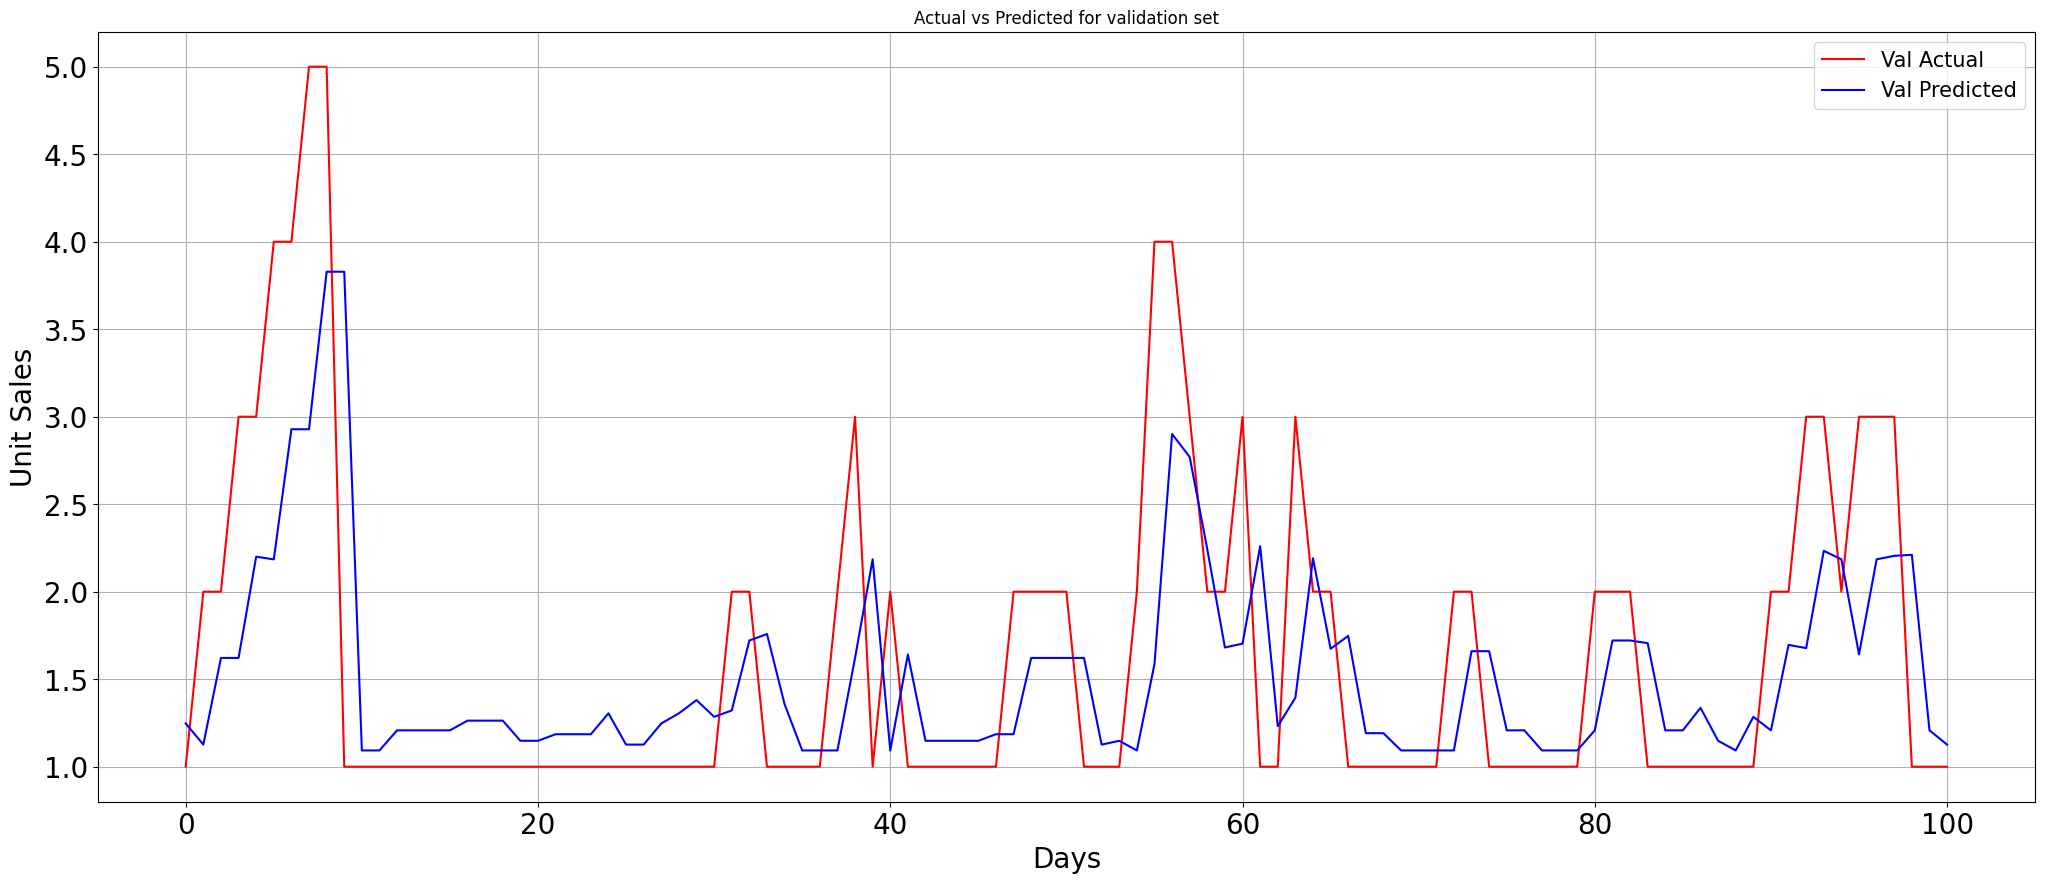

In [400]:
len_val = range(len(X_val))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_val[:101],y_val[:101], label = 'Val Actual',color = 'red')
plt.plot(len_val[:101],y_val_predicted1[:101], label = 'Val Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = 15)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.title('Actual vs Predicted for validation set')
plt.show()

In [401]:
print("MAE: ",mean_absolute_error(y_val,y_val_predicted1))
print("MSE: ",mean_squared_error(y_val,y_val_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_val,y_val_predicted1)))

MAE:  0.44127840188833384
MSE:  0.39202869698242115
RMSE:  0.6261219505674762


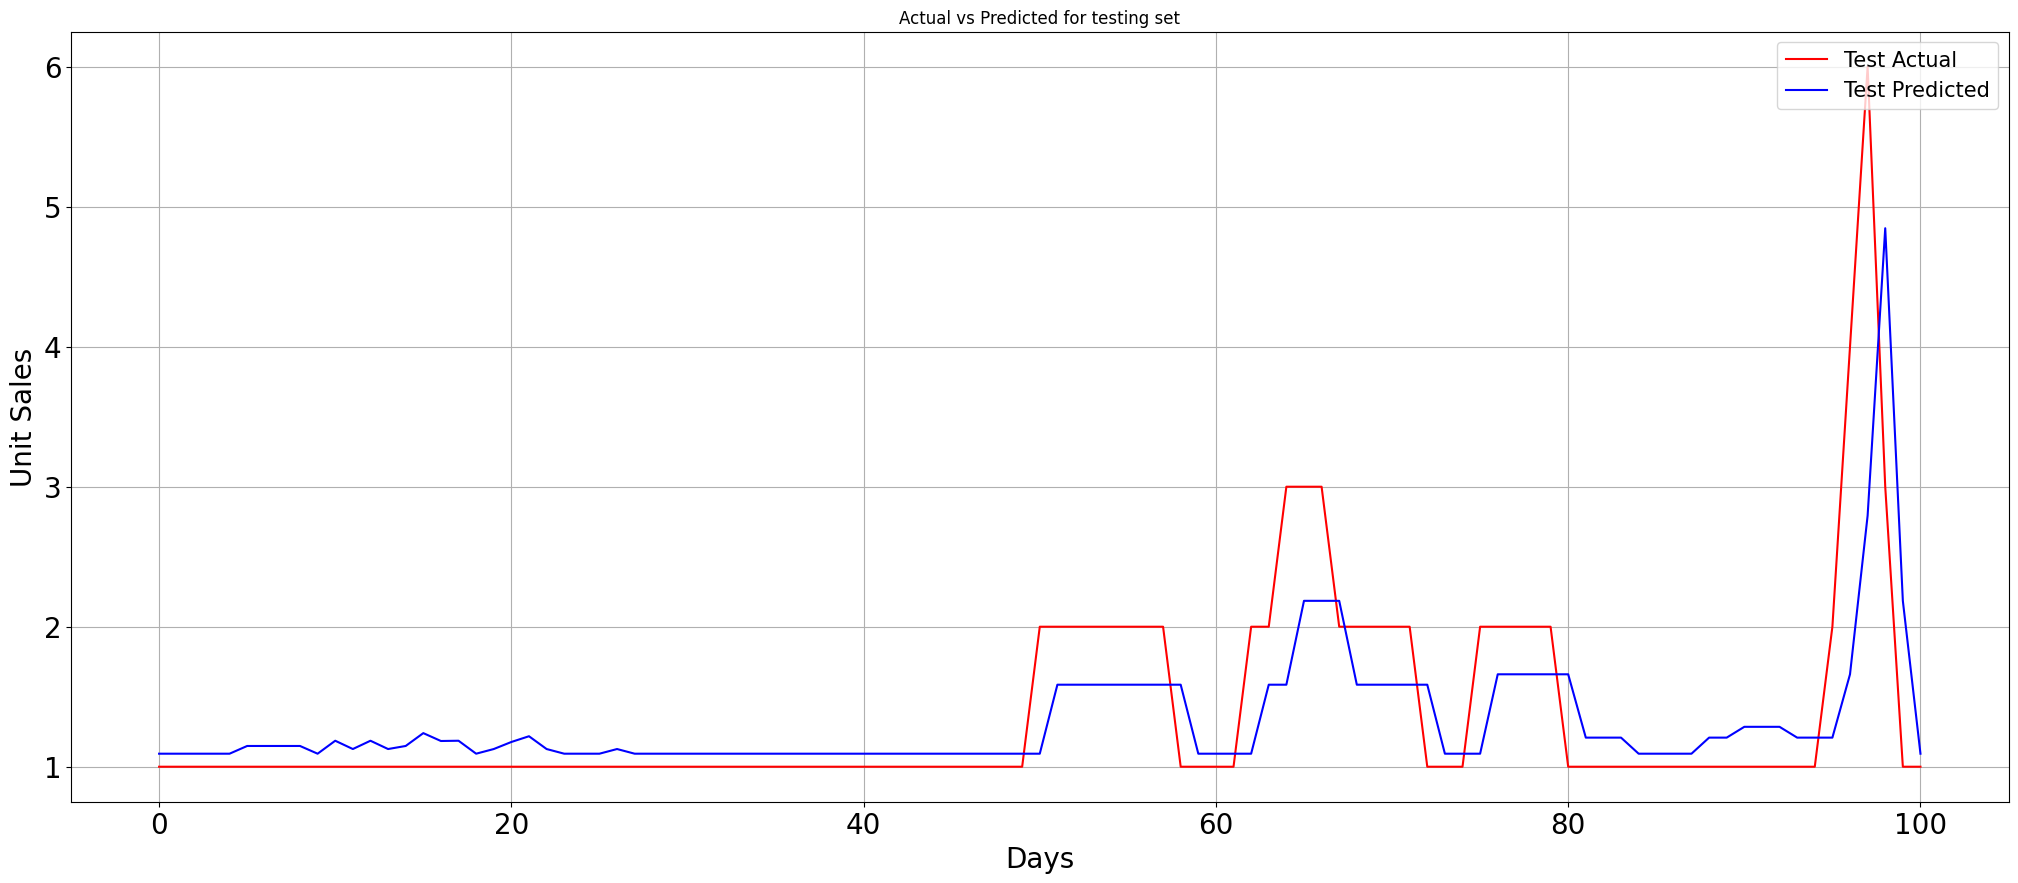

In [402]:
len_test = range(len(X_test))
fig2 = plt.subplots(figsize = (25,10))
plt.plot(len_test[:101],y_test[:101], label = 'Test Actual',color = 'red')
plt.plot(len_test[:101],y_test_predicted1[:101], label = 'Test Predicted',color = 'blue')
plt.xlabel('Days',fontsize = 20)
plt.ylabel('Unit Sales',fontsize = 20)
plt.grid(True)
plt.legend(loc = 'upper right',fontsize = '15')
plt.xticks(fontsize = '20')
plt.yticks(fontsize = '20')
plt.title('Actual vs Predicted for testing set')
plt.show()

In [403]:
print("MAE: ",mean_absolute_error(y_test,y_test_predicted1))
print("MSE: ",mean_squared_error(y_test,y_test_predicted1))
print("RMSE: ",math.sqrt(mean_squared_error(y_test,y_test_predicted1)))

MAE:  0.34342472406534047
MSE:  0.2978763706241291
RMSE:  0.5457805150645533
